Epoch 1/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9141
Epoch 1: val_loss improved from inf to 0.50522, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9117 - val_loss: 0.5052
Epoch 2/50
236/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5380
Epoch 2: val_loss improved from 0.50522 to 0.39717, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5355 - val_loss: 0.3972
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4221
Epoch 3: val_loss improved from 0.39717 to 0.34189, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4221 - val_loss: 0.3419
Epoch 4/50
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3701
Epoch 4: val_loss improved from 0.34189 to 0.30028, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3699 - val_loss: 0.3003
Epoch 5/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

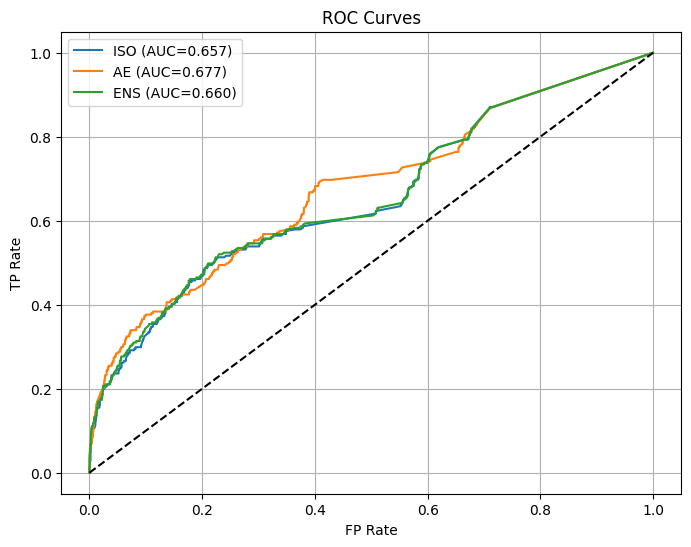

,fraude,scores
46116,False,"{'iso': 0.4811978700912902, 'ae': 0.0781145199..."
23080,False,"{'iso': 0.31846259550310646, 'ae': 0.032979014..."
16307,False,"{'iso': 0.3021879965093941, 'ae': 0.0003300497..."
47134,False,"{'iso': 0.3021879965093941, 'ae': 0.0003300497..."
44347,True,"{'iso': 0.4547484966338087, 'ae': 0.5023514568..."


In [10]:
# Sistema de Detecção de Fraudes em Tempo Real - Otimizado para Colab
# Desenvolvido para MG Contécnica

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import gc
import time
import joblib
import tensorflow as tf
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score,
    precision_recall_curve, roc_curve
)
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")


def limpar_memoria():
    gc.collect()
    tf.keras.backend.clear_session()


def normalize(scores: np.ndarray) -> np.ndarray:
    mn, mx = scores.min(), scores.max()
    den = mx - mn
    if den < 1e-8:
        return scores.copy()
    return (scores - mn) / den


def carregar_dados_em_chunks(diretorio='sample_data/dados/', chunk_size=10_000, max_rows=100_000):
    logging.info(f"Carregando dados de {diretorio} em chunks de {chunk_size} linhas (até {max_rows} registros)...")
    try:
        tx_chunks, total = [], 0
        for chunk in pd.read_csv(f"{diretorio}train_transaction.csv", chunksize=chunk_size):
            if total >= max_rows: break
            tx_chunks.append(chunk)
            total += len(chunk)
            limpar_memoria()
        df_tx = pd.concat(tx_chunks).sample(min(max_rows, total), random_state=42)
        logging.info(f"Transações carregadas: {df_tx.shape}")
    except Exception as e:
        logging.error(f"Erro ao carregar transações: {e}")
        return None, None

    try:
        ids = set(df_tx['TransactionID'])
        id_chunks = []
        for chunk in pd.read_csv(f"{diretorio}train_identity.csv", chunksize=chunk_size):
            filt = chunk[chunk['TransactionID'].isin(ids)]
            if not filt.empty:
                id_chunks.append(filt)
            limpar_memoria()
        if id_chunks:
            df = df_tx.merge(pd.concat(id_chunks), on='TransactionID', how='left')
            logging.info(f"Dados mesclados: {df.shape}")
        else:
            logging.warning("Nenhum dado de identidade encontrado; usando só transações.")
            df = df_tx
    except Exception as e:
        logging.warning(f"Falha ao carregar identidade: {e}")
        df = df_tx

    limpar_memoria()
    return df, df_tx['isFraud'].value_counts()


def analisar_dados(df: pd.DataFrame, amostra_size=10_000):
    logging.info("Analisando dados iniciais...")
    sample = df.sample(amostra_size, random_state=42) if len(df) > amostra_size else df
    logging.info(f"Dimensões: {df.shape}")
    logging.info(f"Distribuição isFraud:\n{df['isFraud'].value_counts()}")
    logging.info(f"% Fraudes: {df['isFraud'].mean()*100:.4f}%")
    logging.info(f"Colunas com nulos: {sample.isnull().any().sum()}")
    logging.info(f"Tipos de dados:\n{sample.dtypes.value_counts()}")


def reduzir_dimensoes(df: pd.DataFrame, max_features=200) -> pd.DataFrame:
    logging.info("Reduzindo dimensionalidade...")
    antes = df.shape[1]
    df = df.drop(columns=df.columns[df.isnull().mean() > 0.7])
    logging.info(f"Removidas {antes - df.shape[1]} colunas >70% nulas")

    num = df.select_dtypes(include=['int64','float64'])
    low_var = [c for c in num if num[c].var() < 0.01 or num[c].nunique() < 2]
    df.drop(columns=low_var, inplace=True)
    logging.info(f"Removidas {len(low_var)} colunas baixa variância")

    if df.shape[1] - 1 > max_features:
        target = df['isFraud']
        corr = df.select_dtypes(include=['int64','float64']).corrwith(target).abs()
        top = corr.drop('isFraud').nlargest(max_features).index
        df = pd.concat([target, df[top]], axis=1)
        logging.info(f"Selecionadas {len(top)} features top correlacionadas")
    logging.info(f"Dimensões finais: {df.shape}")
    return df


def preprocessar_dados(df: pd.DataFrame, test_size=0.2):
    logging.info("Pré-processando dados...")
    y = df.pop('isFraud')
    X = df.drop(columns=[c for c in ['TransactionID','TransactionDT'] if c in df], errors='ignore')
    for c in X.select_dtypes('object'):
        X[c], _ = pd.factorize(X[c])
    for c in X:
        if X[c].isnull().any():
            X[c].fillna(X[c].median(), inplace=True)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    limpar_memoria()
    return X_tr, X_te, y_tr, y_te, X_tr_s, X_te_s, scaler


def treinar_isolation_forest(X_tr_s, y_tr, X_te_s, y_te):
    logging.info("Treinando Isolation Forest...")
    iso = IsolationForest(
        n_estimators=100,
        contamination=y_tr.mean(),
        random_state=42,
        n_jobs=-1
    )
    # treinar amostrado se muito grande
    sample_idx = np.random.choice(len(X_tr_s), min(len(X_tr_s), 50_000), replace=False)
    iso.fit(X_tr_s[sample_idx])
    iso_s = normalize(-iso.score_samples(X_te_s))
    limpar_memoria()
    return iso, iso_s


def treinar_autoencoder(X_tr_s, y_tr, X_te_s, y_te):
    logging.info("Treinando Autoencoder...")
    in_dim = X_tr_s.shape[1]
    enc_dim = min(in_dim // 3, 64)
    hid_dim = min(enc_dim // 2, 32)

    inp = Input((in_dim,))
    x = Dense(enc_dim, activation='relu',
              activity_regularizer=regularizers.l1(1e-5))(inp)
    x = BatchNormalization()(x)
    x = Dense(hid_dim, activation='relu')(x)
    x = Dense(hid_dim, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(enc_dim, activation='relu')(x)
    out = Dense(in_dim, activation='linear')(x)

    ae = Model(inp, out)
    ae.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    ck = ModelCheckpoint('autoencoder_best_model.keras',
                         monitor='val_loss',
                         save_best_only=True,
                         verbose=1)

    sample_idx = np.random.choice(len(X_tr_s), min(len(X_tr_s), 50_000), replace=False)
    X_sample = X_tr_s[sample_idx]
    X_ae, X_val = train_test_split(X_sample, test_size=0.2, random_state=42)

    ae.fit(
        X_ae, X_ae,
        epochs=50,
        batch_size=128,
        validation_data=(X_val, X_val),
        callbacks=[es, ck],
        verbose=1
    )

    ae = load_model('autoencoder_best_model.keras')
    mse_list = []
    bs = 10_000
    for i in range(0, len(X_te_s), bs):
        pred = ae.predict(X_te_s[i:i+bs], verbose=0)
        mse_list.append(np.mean((X_te_s[i:i+bs] - pred)**2, axis=1))
    ae_s = normalize(np.concatenate(mse_list))
    limpar_memoria()
    return ae, ae_s


def avaliar_modelos(y_te, iso_s, ae_s):
    logging.info("Avaliando modelos e traçando ROC...")

    def achar_thr(scores):
        p, r, t = precision_recall_curve(y_te, scores)
        f1 = 2 * p * r / (p + r + 1e-10)
        return t[np.argmax(f1)]

    t_iso = achar_thr(iso_s)
    t_ae = achar_thr(ae_s)
    t_en = (t_iso + t_ae) / 2.0

    y_iso = (iso_s >= t_iso).astype(int)
    y_ae = (ae_s >= t_ae).astype(int)
    y_en = np.logical_or(y_iso, y_ae).astype(int)

    logging.info("Isolation Forest:\n" + classification_report(y_te, y_iso))
    logging.info("Autoencoder:\n" + classification_report(y_te, y_ae))
    logging.info("Ensemble:\n" + classification_report(y_te, y_en))

    auc_iso = roc_auc_score(y_te, iso_s)
    auc_ae = roc_auc_score(y_te, ae_s)
    auc_en = roc_auc_score(y_te, (iso_s + ae_s) / 2.0)
    logging.info(f"AUCs — ISO: {auc_iso:.4f}, AE: {auc_ae:.4f}, ENS: {auc_en:.4f}")

    plt.figure(figsize=(8, 6))
    for scores, name, auc in [(iso_s, "ISO", auc_iso),
                              (ae_s, "AE", auc_ae),
                              ((iso_s + ae_s) / 2.0, "ENS", auc_en)]:
        fpr, tpr, _ = roc_curve(y_te, scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FP Rate")
    plt.ylabel("TP Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"threshold_iso": t_iso,
            "threshold_ae": t_ae,
            "threshold_ensemble": t_en}


def implementar_sistema_tempo_real(iso, ae, scaler, perf):
    t_iso = perf["threshold_iso"]
    t_ae = perf["threshold_ae"]
    t_en = perf["threshold_ensemble"]

    def detectar(trans: pd.DataFrame):
        df = trans.copy()
        for c in ['TransactionID', 'TransactionDT']:
            if c in df: df.drop(c, axis=1, inplace=True)
        for c in df.select_dtypes('object'):
            df[c], _ = pd.factorize(df[c])
        df.fillna(df.median(), inplace=True)

        Xs = scaler.transform(df)
        iso_s = normalize(-iso.score_samples(Xs))
        recon = ae.predict(Xs, verbose=0)
        ae_s = normalize(np.mean((Xs - recon)**2, axis=1))
        ens_s = (iso_s + ae_s) / 2.0

        return {
            "fraude": bool(ens_s[0] >= t_en),
            "scores": {"iso": float(iso_s[0]),
                       "ae": float(ae_s[0]),
                       "ens": float(ens_s[0])}
        }
    return detectar


def executar_sistema():
    df, _ = carregar_dados_em_chunks(chunk_size=5_000, max_rows=50_000)
    if df is None:
        return None, None

    analisar_dados(df)
    df = reduzir_dimensoes(df, max_features=100)
    X_tr, X_te, y_tr, y_te, X_tr_s, X_te_s, scaler = preprocessar_dados(df)

    iso, iso_s = treinar_isolation_forest(X_tr_s, y_tr, X_te_s, y_te)
    ae, ae_s = treinar_autoencoder(X_tr_s, y_tr, X_te_s, y_te)

    perf = avaliar_modelos(y_te, iso_s, ae_s)
    detector = implementar_sistema_tempo_real(iso, ae, scaler, perf)
    return detector, X_te


if __name__ == "__main__":
    detector, X_test = executar_sistema()
    if detector is not None and X_test is not None:
        exemplos = X_test.sample(5, random_state=42)
        resultados = {
            idx: detector(exemplos.loc[[idx]])
            for idx in exemplos.index
        }
        df_res = pd.DataFrame.from_dict(resultados, orient="index")
        display(df_res)

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, roc_auc_score

def calibrar_thresholds(y_true: np.ndarray,
                       scores: np.ndarray,
                       model_name: str,
                       grid: np.ndarray = None) -> pd.DataFrame:
    """
    Varia threshold de 0 a 1 (ou uma grade customizada),
    computa precision, recall, f1 e AUC para cada ponto,
    retorna DataFrame com métricas.
    """
    if grid is None:
        grid = np.linspace(0, 1, 101)
    records = []
    auc = roc_auc_score(y_true, scores)
    for t in grid:
        y_pred = (scores >= t).astype(int)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        records.append({
            "model": model_name,
            "threshold": t,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "auc": auc
        })
    return pd.DataFrame.from_records(records)


Epoch 1/50
241/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9094
Epoch 1: val_loss improved from inf to 0.48788, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9021 - val_loss: 0.4879
Epoch 2/50
240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5112
Epoch 2: val_loss improved from 0.48788 to 0.40811, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5101 - val_loss: 0.4081
Epoch 3/50
239/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4081
Epoch 3: val_loss improved from 0.40811 to 0.35113, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4082 - val_loss: 0.3511
Epoch 4/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3572
Epoch 4: val_loss improved from 0.35113 to 0.32016, saving model to autoencoder_best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3572 - val_loss: 0.3202
Epoch 5/50
241/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

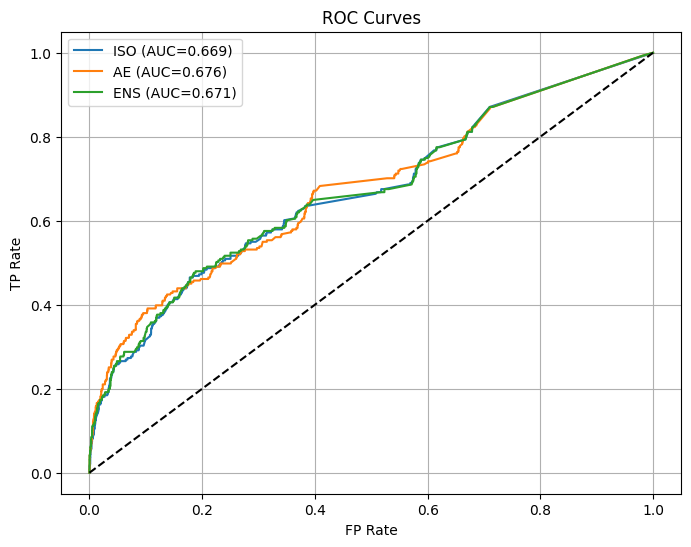

Dados prontos: y_test, iso_scores, ae_scores, ensemble_scores


In [19]:
# === Célula: (Re)treina ou recarrega pipeline e prepara os scores ===
# IMPORTS e definição de executar_sistema(), treinar_xxx() etc. já devem estar rodados

# Se você já rodou executar_sistema() antes e salvou os modelos em disco,
# pode recarregá-los em vez de treinar de novo:
# iso = joblib.load('isolation_forest_model.joblib')
# ae  = load_model('autoencoder_best_model.keras')
# scaler = joblib.load('scaler.pkl')   # se você salvou o scaler também

# Mas se for treinar tudo na hora:
detector, X_test, y_test, iso_scores, ae_scores = None, None, None, None, None

# Vamos treinar de novo (ou adaptar executar_sistema para retornar esses valores):
def executar_para_calibracao():
    # retorna também y_test e os scores
    df, _            = carregar_dados_em_chunks(chunk_size=5000, max_rows=50000)
    df               = reduzir_dimensoes(df, max_features=100)
    X_tr, X_te, y_tr, y_te, X_tr_s, X_te_s, scaler = preprocessar_dados(df)
    iso, iso_s       = treinar_isolation_forest(X_tr_s, y_tr, X_te_s, y_te)
    ae, ae_s         = treinar_autoencoder(X_tr_s, y_tr, X_te_s, y_te)
    ensemble_s       = (iso_s + ae_s) / 2.0
    detector         = implementar_sistema_tempo_real(iso, ae, scaler, avaliar_modelos(y_te, iso_s, ae_s))
    return detector, X_te, y_te, iso_s, ae_s, ensemble_s

detector, X_test, y_test, iso_scores, ae_scores, ensemble_scores = executar_para_calibracao()
print("Dados prontos: y_test, iso_scores, ae_scores, ensemble_scores")


In [20]:
df_iso = calibrar_thresholds(y_test.values, iso_scores, "IsolationForest")
df_ae  = calibrar_thresholds(y_test.values, ae_scores,  "Autoencoder")
df_ens = calibrar_thresholds(y_test.values, ensemble_scores, "Ensemble")

best_iso = df_iso.loc[df_iso.f1.idxmax()]
best_ae  = df_ae.loc[df_ae.f1.idxmax()]
best_ens = df_ens.loc[df_ens.f1.idxmax()]

print("Melhor ISO:", best_iso.threshold, "F1:", best_iso.f1)
print("Melhor AE :", best_ae.threshold,  "F1:", best_ae.f1)
print("Melhor ENS:", best_ens.threshold, "F1:", best_ens.f1)


Melhor ISO: 0.59 F1: 0.18181818181818182
Melhor AE : 0.06 F1: 0.20187793427230047
Melhor ENS: 0.33 F1: 0.18803418803418803


In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def calibrar_por_custo(y_true: np.ndarray,
                      scores: np.ndarray,
                      grid: np.ndarray = None,
                      custo_fp: float = 10,
                      custo_fn: float = 1000) -> pd.DataFrame:
    """
    Para cada threshold em `grid`, calcula custo = fp*custo_fp + fn*custo_fn.
    Retorna DataFrame com threshold, fp, fn, custo.
    """
    if grid is None:
        grid = np.linspace(0, 1, 101)
    rows = []
    for t in grid:
        y_pred = (scores >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        custo = fp * custo_fp + fn * custo_fn
        rows.append({
            "threshold": t,
            "fp": int(fp),
            "fn": int(fn),
            "custo": custo
        })
    return pd.DataFrame(rows)

# --- Uso no seu ensemble ---
custo_fp = 10      # ex.: R$10 por alerta falso
custo_fn = 1000    # ex.: R$1000 por fraude não pega
df_custo = calibrar_por_custo(
    y_true=y_test.values,
    scores=ensemble_scores,
    grid=np.linspace(0,1,201),
    custo_fp=custo_fp,
    custo_fn=custo_fn
)

# Encontra o threshold que minimiza custo
best = df_custo.loc[df_custo.custo.idxmin()]
print("Threshold custo-ótimo:", best.threshold)
print("FP:", best.fp, "FN:", best.fn, "Custo total:", best.custo)

# Exiba os top 10 thresholds mais baratos
display(df_custo.nsmallest(10, "custo"))


Threshold custo-ótimo: 0.0
FP: 9729.0 FN: 0.0 Custo total: 97290.0


,threshold,fp,fn,custo
0,0.000,9729,0,97290
1,0.005,5811,68,126110
2,0.010,5632,78,134320
3,0.015,5037,90,140370
5,0.025,3049,115,145490
4,0.020,3369,112,145690
6,0.030,2729,123,150290
7,0.035,2538,129,154380
8,0.040,2359,131,154590
9,0.045,2225,134,156250


from matplotlib import pyplot as plt
_df_0['threshold'].plot(kind='hist', bins=20, title='threshold')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['fp'].plot(kind='hist', bins=20, title='fp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['fn'].plot(kind='hist', bins=20, title='fn')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['custo'].plot(kind='hist', bins=20, title='custo')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='threshold', y='fp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='fp', y='fn', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='fn', y='custo', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['custo']
  ys = series['threshold']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('custo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('custo')
_ = plt.ylabel('threshold')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['custo']
  ys = series['fp']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('custo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('custo')
_ = plt.ylabel('fp')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['custo']
  ys = series['fn']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('custo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('custo')
_ = plt.ylabel('fn')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['custo']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'custo'}, axis=1)
              .sort_values('custo', ascending=True))
  xs = counted['custo']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('custo', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('custo')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['threshold'].plot(kind='line', figsize=(8, 4), title='threshold')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['fp'].plot(kind='line', figsize=(8, 4), title='fp')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['fn'].plot(kind='line', figsize=(8, 4), title='fn')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['custo'].plot(kind='line', figsize=(8, 4), title='custo')
plt.gca().spines[['top', 'right']].set_visible(False)

In [25]:
# Teste diferentes custos de FN em [100, 500, 1000, 2000]
for custo_fn in [100, 500, 1000, 2000]:
    df_c = calibrar_por_custo(
        y_test.values,
        ensemble_scores,
        grid=np.linspace(0,1,101),
        custo_fp=10,
        custo_fn=custo_fn
    )
    best = df_c.loc[df_c.custo.idxmin()]
    print(f"custo_fn={custo_fn:5d} -> t*={best.threshold:.3f}, custo={best.custo:.0f}, FP={best.fp}, FN={best.fn}")


custo_fn=  100 -> t*=0.330, custo=24230, FP=153.0, FN=227.0
custo_fn=  500 -> t*=0.030, custo=88790, FP=2729.0, FN=123.0
custo_fn= 1000 -> t*=0.000, custo=97290, FP=9729.0, FN=0.0
custo_fn= 2000 -> t*=0.000, custo=97290, FP=9729.0, FN=0.0


In [26]:
# 1. Recalibra com custo realista
df_custo = calibrar_por_custo(
    y_test.values,
    ensemble_scores,
    grid=np.linspace(0,1,101),
    custo_fp=10,
    custo_fn=100
)

# 2. Define piso para descartar ruído
piso = 0.05
df_filtrado = df_custo[df_custo.threshold >= piso]

# 3. Seleciona threshold de menor custo
best = df_filtrado.loc[df_filtrado.custo.idxmin()]
print(f"Threshold final: {best.threshold:.2f}")
print(f"FP: {best.fp}, FN: {best.fn}, Custo: {best.custo:.0f}")


Threshold final: 0.33
FP: 153.0, FN: 227.0, Custo: 24230
